In [2]:
# import shutil
# shutil.rmtree('/app/_data/npy/long_mels_nocall/')

In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile
import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.gen_long_nocall import MEL_Generator, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 37
IMG_SIZE = 224
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 50

## Initial dataframes

In [3]:
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls_1s.csv")
call = pd.read_csv("/app/_data/labels_nocall/all_calls_1s.csv")
bad = pd.read_csv("/app/_data/labels_nocall/bad_parts_05s.csv")

In [4]:
nocall["label_id"] = 0
call["label_id"] = 1
bad['label_id']=2

In [5]:
nocall[nocall['file_path'].str.contains('train_soundscapes')]

,filename,row_id,start_sec,end_sec,birds,file_path,duration,label_id
0,7019_COR_20190904.ogg,7019_COR_20190904_5_0,0.00,5.00,nocall,/app/_data/birdclef-2021/train_soundscapes/701...,600.0,0
1,7019_COR_20190904.ogg,7019_COR_20190904_5_09,0.09,5.09,nocall,/app/_data/birdclef-2021/train_soundscapes/701...,600.0,0
2,7019_COR_20190904.ogg,7019_COR_20190904_5_19,0.19,5.19,nocall,/app/_data/birdclef-2021/train_soundscapes/701...,600.0,0
3,7019_COR_20190904.ogg,7019_COR_20190904_5_29,0.29,5.29,nocall,/app/_data/birdclef-2021/train_soundscapes/701...,600.0,0
4,7019_COR_20190904.ogg,7019_COR_20190904_5_39,0.39,5.39,nocall,/app/_data/birdclef-2021/train_soundscapes/701...,600.0,0
...,...,...,...,...,...,...,...,...
68067,54955_SSW_20170617.ogg,54955_SSW_20170617_599_5,594.50,599.50,nocall,/app/_data/birdclef-2021/train_soundscapes/549...,600.0,0
68068,54955_SSW_20170617.ogg,54955_SSW_20170617_599_6,594.60,599.60,nocall,/app/_data/birdclef-2021/train_soundscapes/549...,600.0,0
68069,54955_SSW_20170617.ogg,54955_SSW_20170617_599_7,594.70,599.70,nocall,/app/_data/birdclef-2021/train_soundscapes/549...,600.0,0
68070,54955_SSW_20170617.ogg,54955_SSW_20170617_599_8,594.80,599.80,nocall,/app/_data/birdclef-2021/train_soundscapes/549...,600.0,0


In [6]:
df = pd.concat([call, nocall, bad], axis=0, ignore_index=True).sample(
    frac=1, random_state=SEED
)

In [7]:
df[df["end_sec"] > df["duration"]]

,filename,row_id,start_sec,end_sec,birds,file_path,duration,label_id


In [8]:
dict_birds = {"nocall": 0, "call": 1, 'bad':2}

In [9]:
df["label_id"].value_counts()

0    84349
1    25539
2       82
Name: label_id, dtype: int64

In [10]:
df["file_path"] = df["file_path"].str.replace("birdclef-2021/", "")

In [11]:
df

,filename,row_id,start_sec,end_sec,birds,file_path,duration,label_id
108446,XC240101.ogg,XC240101_28_71,23.71,28.71,nocall,/app/_data/train_short_audio/acafly/XC240101.ogg,52.80,0
37707,11254_COR_20190904.ogg,11254_COR_20190904_56_6,51.60,56.60,nocall,/app/_data/train_soundscapes/11254_COR_2019090...,600.00,0
94561,XC483212.ogg,XC483212_28_22,23.22,28.22,nocall,/app/_data/train_short_audio/amekes/XC483212.ogg,104.00,0
18206,XC168589.ogg,XC168589_5_0,0.00,5.00,whwdov,/app/_data/train_short_audio/whwdov/XC168589.ogg,23.57,1
64419,7843_SSW_20170325.ogg,7843_SSW_20170325_35_39,30.39,35.39,nocall,/app/_data/train_soundscapes/7843_SSW_20170325...,600.00,0
...,...,...,...,...,...,...,...,...
66524,7843_SSW_20170325.ogg,7843_SSW_20170325_245_89,240.89,245.89,nocall,/app/_data/train_soundscapes/7843_SSW_20170325...,600.00,0
30971,7019_COR_20190904.ogg,7019_COR_20190904_548_19,543.19,548.19,nocall,/app/_data/train_soundscapes/7019_COR_20190904...,600.00,0
74572,14473_SSW_20170701.ogg,14473_SSW_20170701_299_79,294.79,299.79,nocall,/app/_data/train_soundscapes/14473_SSW_2017070...,600.00,0
20843,XC448929.ogg,XC448929_79_18,74.18,79.18,andsol1,/app/_data/train_short_audio/andsol1/XC448929.ogg,81.25,1


# train_test_split

In [12]:
df[df['end_sec']>df['duration']]

,filename,row_id,start_sec,end_sec,birds,file_path,duration,label_id


In [13]:
train, t_v = train_test_split(df, train_size=0.7, random_state=SEED)
valid, test = train_test_split(t_v, train_size=0.5, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [14]:
train.shape
valid.shape
test.shape

(76979, 8)

(16495, 8)

(16496, 8)

In [15]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
)

In [16]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="min",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/nocall/eff0_nocall_3.h5",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="min",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(
        log_dir="/app/.tensorboard/nocall_9/", histogram_freq=0
    ),
    keras.callbacks.experimental.BackupAndRestore("/app/_data/models/nocall/backup/"),
    keras.callbacks.TerminateOnNaN(),
]

In [17]:
def get_model():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = keras.applications.EfficientNetB0(
        weights="imagenet", include_top=False
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
        ],
    )
    return model

In [18]:
policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [19]:
# for i in [
#     "/app/_data/npy/short_mels_test/",
#     "/app/_data/npy/long_mels_nocall/",
#     "/app/_data/npy/short_mels_nocall/",
# ]:
#     shutil.rmtree(i)

In [20]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 410

In [21]:
NUM_CLASSES

3

In [22]:
gen_train = MEL_Generator(
    df=train,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    long_mel_dir="/app/_data/npy/long_mels_nocall/",
    short_mel_dir="/app/_data/npy/short_mels_nocall/",
    convert_to_rgb=True,
    shuffle=True,
)

gen_valid = MEL_Generator(
    df=valid,
    n_mels=IMG_SIZE,
    seed=SEED,
    n_classes = NUM_CLASSES,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    long_mel_dir="/app/_data/npy/long_mels_nocall/",
    short_mel_dir="/app/_data/npy/short_mels_nocall/",
    convert_to_rgb=True,
    shuffle=False,
)
gen_test = MEL_Generator(
    df=test,
    n_mels=IMG_SIZE,
    seed=SEED,
    n_classes = NUM_CLASSES,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_nocall/",
    long_mel_dir="/app/_data/npy/long_mels_nocall/",
    convert_to_rgb=True,
    shuffle=False,
)

In [23]:
# os.mkdir('/app/_data/npy/short_mels_nocall/')
# shutil.rmtree('/app/_data/npy/long_mels_nocall/')

In [24]:
gen_train.__len__()

187

In [25]:
# plt.imshow(a[0][4])
# a[1][4]

In [26]:
model = get_model()

In [27]:
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE-1,
    validation_steps=valid.shape[0] // BATCH_SIZE-1,
    verbose=1,
    max_queue_size=50,
    workers=20,
    callbacks=callbacks,
)

Epoch 1/100
  1/186 [..............................] - ETA: 0s - loss: 0.7192 - acc: 0.3000 - recall: 0.5512 - precision: 0.3388WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
186/186 [==============================] - ETA: 0s - loss: 0.0524 - acc: 0.9751 - recall: 0.9763 - precision: 0.9711
Epoch 00001: val_loss improved from inf to 0.06825, saving model to /app/_data/models/nocall/eff0_nocall_3.h5
186/186 [==============================] - 238s 1s/step - loss: 0.0524 - acc: 0.9751 - recall: 0.9763 - precision: 0.9711 - val_loss: 0.0682 - val_acc: 0.9664 - val_recall: 0.9672 - val_precision: 0.9655
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 0.0157 - acc: 0.9928 - recall: 0.9927 - precision: 0.9929
Epoch 00002: val_loss improved fro

In [ ]:
model.evaluate(gen_test)

16/40 [===========>..................] - ETA: 5:01 - loss: 0.0152 - acc: 0.9953 - recall: 0.9950 - precision: 0.9956

In [26]:
pred = model.predict(gen_test)

In [35]:
a = gen_test.__getitem__(11)
b= model.predict(a)

In [36]:
for i in range(410):
    if np.argmax(b[i])!= np.argmax(a[1][i]):
        print(i, np.argmax(b[i]), np.argmax(a[1][i]))

67 0 1


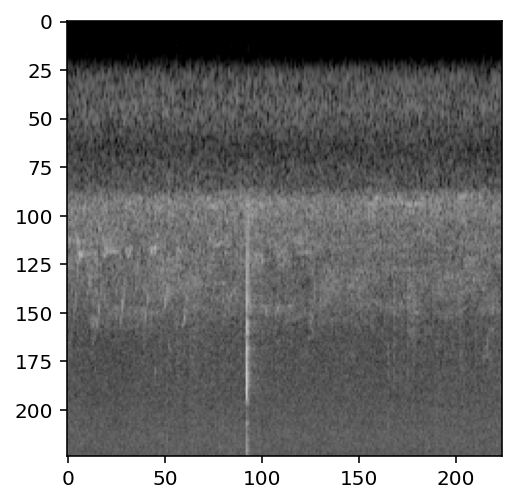

In [38]:
plt.imshow(a[0][67])